# On dry land

**++ Currently, the examples are being reworked after the latest update because GBIF behaves differently now. [Find out more](/updates/updates_and_changes.html) ++**

This workflow uses the VAT to evaluate the distribution of *Calopteryx splendens* in dependence of the land use classification from the Ökosystematlas and a temporal aggregation of the average air temperature. 

The purpose of this notebook is to demonstrate the capabilities of Geo Engine. Therefore, some useful techniques will be shown: 
- Using the GBIF data catalogue
- Point in polygon selection
- Raster vector join of occurrence data with land use classification
- Plotting a class histogram
- Nested workflows

When building your own nested workflow, it is recommended to build it in several steps as shown in this notebook.

Documentation about the operators and how to use them in Python can be found here: [https://docs.geoengine.io/operators/intro.html](https://docs.geoengine.io/operators/intro.html)

## Preparation

In [1]:
#Import packages
import geoengine as ge
import geoengine_openapi_client
from datetime import datetime
from geoengine.types import RasterBandDescriptor
import altair as alt
import asyncio
import nest_asyncio

alt.renderers.enable('default')

RendererRegistry.enable('default')

In [2]:
#Initialize Geo Engine in VAT
ge.initialize("https://vat.gfbio.org/api")

In [3]:
#Get the GBIF DataProvider id (Useful for translating the DataProvider name to its id)
root_collection = ge.layer_collection()
gbif_prov_id = ''
for elem in root_collection.items:
    if elem.name == 'GBIF':
        gbif_prov_id = str(elem.provider_id)
        
gbif_prov_id

'1c01dbb9-e3ab-f9a2-06f5-228ba4b6bf7a'

## Load boundaries of Germany for later GBIF occurrence extraction (optional)

This chapter is not needed and only shows that country boundaries are available

In [4]:
#Create workflow to request germany boundary
workflow_germany = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": "germany",
        }
    }
})

workflow_germany

2429a993-385f-546f-b4f7-97b3ba4a5adb

<Axes: >

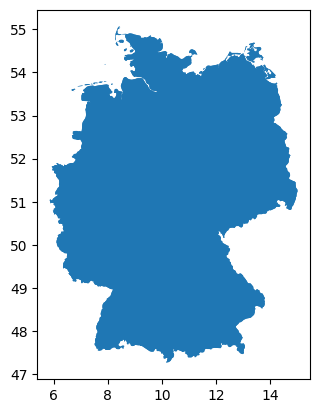

In [5]:
#Set time
start_time = datetime.strptime(
    '2010-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
end_time = datetime.strptime(
    '2011-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_germany.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

## Load Ökosystematlas (detailed) for later raster vector join with occurrence data (optional)

This chapter is not needed and only shows that raster data is also available.

In [6]:
#Create workflow to request the oekosystematlas raster data
workflow_oekosystematlas = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": "oekosystematlas_detail"
        }
    }
})

workflow_oekosystematlas

f447601c-0ba1-57c3-9127-b0622f982231

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


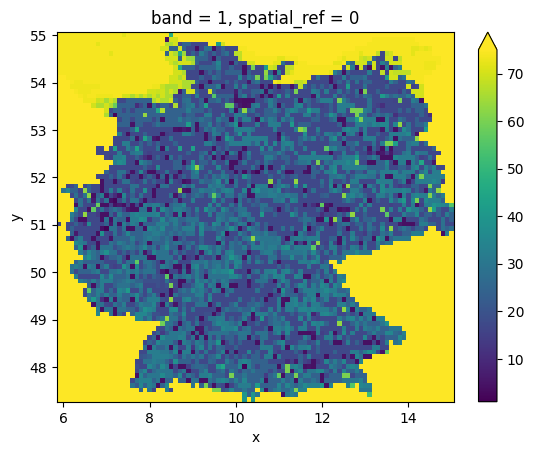

In [7]:
#Request the data from Geo Engine into a xarray dataarray
data = workflow_oekosystematlas.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmax=75)

## Load Average temperature for later raster vector join with event data (optional)

This chapter is not needed and only shows that raster data is also available.

In [8]:
#Create workflow to request the average temperature raster data
workflow_t_avg = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "RasterScaling",
            "params": {
                "slope": {
                    "type": "constant",
                    "value": 0.1
                },
                "offset": {
                    "type": "constant",
                    "value": -273.15
                },
                "outputMeasurement": {
                    "type": "continuous",
                    "measurement": "temperature",
                    "unit": "K/10"
                },
                "scalingMode": "mulSlopeAddOffset"
            },
            "sources": {
                "raster": {
                    "type": "RasterTypeConversion",
                    "params": {
                        "outputDataType": "F32"
                    },
                    "sources": {
                        "raster": {
                            "type": "GdalSource",
                            "params": {
                                "data": "mean_daily_air_temperature"
                            }
                        }
                    }
                }
            }
    }
})

workflow_t_avg

6393648d-6545-5435-a49e-015ba9dfa92e

In [9]:
#Preparing of the boundaries for the workflow raster stream
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
    ge.TimeInterval(start_time, end_time),
    resolution=ge.SpatialResolution(0.1, 0.1),
    srs="EPSG:4326"
)

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


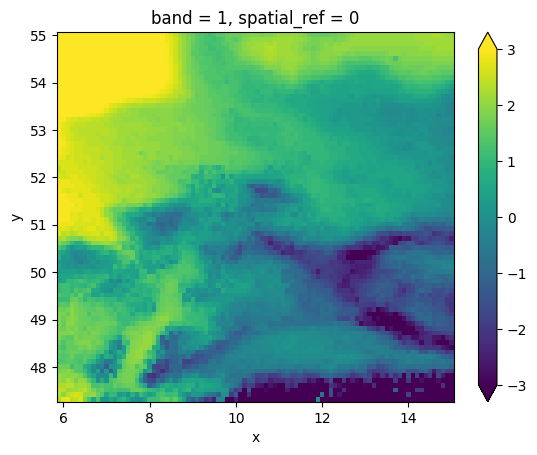

In [10]:
#Request the data from Geo Engine into a xarray dataarray
data = workflow_t_avg.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, start_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmin=-3, vmax=3)

## Processing *Calopteryx splendens*

None of the following steps are necessary in theory, as the entire workflow will be projected in the nested request in the end. However, the steps are intended to show the capabilities of Geo Engine and how to logically build nested workflows.

### Load *Calopteryx splendens* (Optional)

In [11]:
#Create workflow to request Calopteryx splendens occurences
workflow_calopteryx_splendens = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
        }
    }
})

workflow_calopteryx_splendens.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:4326
Columns:
  scientificname:
    Column Type: text
    Measurement: unitless
  basisofrecord:
    Column Type: text
    Measurement: unitless
  gbifid:
    Column Type: int
    Measurement: unitless

<Axes: >

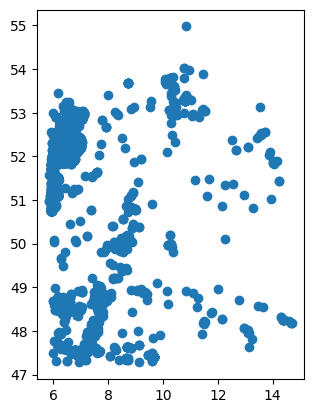

In [12]:
#Request the data from Geo Engine into a geopandas dataframe
data = workflow_calopteryx_splendens.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

### Point in Polygon *Calopteryx splendens*

In [13]:
#Create workflow to request Calopteryx splendens occurrences filtered by German border
workflow_calopteryx_splendens_cut = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "PointInPolygonFilter",
        "params": {},
        "sources": {
            "points": { #Calopteryx splendens ###############################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                    "attributeProjection": []
                } 
            }, #####################################################
            "polygons": { #Germany #################################
                "type": "OgrSource",
                "params": {
                    "data": "germany"
                }
            } ######################################################
        } 
    }
})

workflow_calopteryx_splendens_cut

6cf9ef88-8bd3-5904-bc74-f866165b18c3

<Axes: >

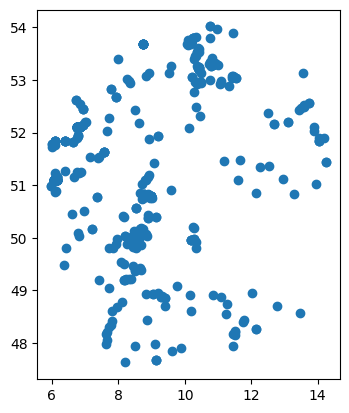

In [14]:
#Request the data from Geo Engine into a geopandas dataframe
data_calopteryx_splendens = workflow_calopteryx_splendens_cut.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data_calopteryx_splendens.plot()

### Nested Point in Polygon and Raster Vector Join *Calopteryx splendens*

In [15]:
#Create a workflow to request Calopteryx splendens occurrences filtered by the German border and linked to the Ökosystematlas data.
workflow_calopteryx_splendens_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
            "names": {
                "type": "names",
                "values": ["Ökosystematlas", "Avg_Temperature"]
            }, 
            "temporalAggregation": "none",
            "featureAggregation": "first",
        },
        "sources": {
            "vector": { #Calopteryx splendens cut ######################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ##############################################################
            "rasters": [{ #Ökosystematlas ###################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }, ##############################################################
            { #Average temperature
                "type": "RasterScaling",
                    "params": {
                        "slope": {
                            "type": "constant",
                            "value": 0.1
                        },
                        "offset": {
                            "type": "constant",
                            "value": -273.15
                        },
                        "outputMeasurement": {
                            "type": "continuous",
                            "measurement": "temperature",
                            "unit": "K/10"
                        },
                        "scalingMode": "mulSlopeAddOffset"
                    },
                    "sources": {
                        "raster": {
                            "type": "RasterTypeConversion",
                            "params": {
                                "outputDataType": "F32"
                            },
                            "sources": {
                                "raster": {
                                    "type": "GdalSource",
                                    "params": {
                                        "data": "mean_daily_air_temperature"
                                    }
                                }
                            }
                        }
                    }
            }] ##############################################################
        },
    }
})

workflow_calopteryx_splendens_cut_join

63c46ba9-3efd-5ddd-b446-c36fad6537e8

In [16]:
#Request the data from Geo Engine into a geopandas dataframe
data = workflow_calopteryx_splendens_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    ),
    resolve_classifications=True
)

#Show the geopandas dataframe
data

,geometry,Avg_Temperature,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (7.57250 51.63501),9.350006,HUMAN_OBSERVATION,920849630,"Calopteryx splendens Harris, 1780",Grünland,2010-04-29 00:00:00+00:00,2010-04-29 00:00:00+00:00
1,POINT (6.75459 52.09421),9.250000,HUMAN_OBSERVATION,700578315,"Calopteryx splendens Harris, 1780",Ackerland,2010-04-12 00:00:00+00:00,2010-04-12 00:00:00+00:00
2,POINT (6.79395 51.93967),9.350006,HUMAN_OBSERVATION,700582646,"Calopteryx splendens Harris, 1780",No data,2010-04-07 00:00:00+00:00,2010-04-07 00:00:00+00:00
3,POINT (6.75459 52.09421),9.250000,HUMAN_OBSERVATION,700578316,"Calopteryx splendens Harris, 1780",Ackerland,2010-04-12 00:00:00+00:00,2010-04-12 00:00:00+00:00
4,POINT (6.79395 51.93967),9.350006,HUMAN_OBSERVATION,700582645,"Calopteryx splendens Harris, 1780",No data,2010-04-07 00:00:00+00:00,2010-04-07 00:00:00+00:00
...,...,...,...,...,...,...,...,...
535,POINT (7.62722 47.98439),NaN,HUMAN_OBSERVATION,3845932111,"Calopteryx splendens Harris, 1780",Ackerland,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
536,POINT (7.79354 48.33831),NaN,HUMAN_OBSERVATION,3844974542,"Calopteryx splendens Harris, 1780",Ackerland,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
537,POINT (7.80175 48.42811),NaN,HUMAN_OBSERVATION,3845548749,"Calopteryx splendens Harris, 1780",Laubwälder,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
538,POINT (8.10648 48.77593),NaN,HUMAN_OBSERVATION,3845803099,"Calopteryx splendens Harris, 1780",Grünland,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00


In [17]:
#Create a workflow to request Calopteryx splendens occurrences filtered by the German border and linked to the Ökosystematlas data.
workflow_calopteryx_splendens_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
            "names": {
                "type": "names",
                "values": ["Ökosystematlas", "Avg_Temperature"]
            }, 
            "temporalAggregation": "none",
            "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Calopteryx splendens cut ######################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ##############################################################
            "rasters": [{ #Ökosystematlas ###################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }, ##############################################################
            { #Average temperature
                "type": "RasterScaling",
                    "params": {
                        "slope": {
                            "type": "constant",
                            "value": 0.1
                        },
                        "offset": {
                            "type": "constant",
                            "value": -273.15
                        },
                        "outputMeasurement": {
                            "type": "continuous",
                            "measurement": "temperature",
                            "unit": "K/10"
                        },
                        "scalingMode": "mulSlopeAddOffset"
                    },
                    "sources": {
                        "raster": {
                            "type": "RasterTypeConversion",
                            "params": {
                                "outputDataType": "F32"
                            },
                            "sources": {
                                "raster": {
                                    "type": "GdalSource",
                                    "params": {
                                        "data": "mean_daily_air_temperature"
                                    }
                                }
                            }
                        }
                    }
            }] ##############################################################
        },
    }
})

workflow_calopteryx_splendens_cut_join

4f2e830a-9570-5c8f-b2e1-bc433814df82

In [18]:
#Request the data from Geo Engine into a geopandas dataframe
data = workflow_calopteryx_splendens_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    ),
    resolve_classifications=True
)

#Show the geopandas dataframe
data

,geometry,Avg_Temperature,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (7.57250 51.63501),9.350006,HUMAN_OBSERVATION,920849630,"Calopteryx splendens Harris, 1780",Grünland,2010-04-29 00:00:00+00:00,2010-04-29 00:00:00+00:00
1,POINT (6.75459 52.09421),9.250000,HUMAN_OBSERVATION,700578315,"Calopteryx splendens Harris, 1780",Ackerland,2010-04-12 00:00:00+00:00,2010-04-12 00:00:00+00:00
2,POINT (6.79395 51.93967),9.350006,HUMAN_OBSERVATION,700582646,"Calopteryx splendens Harris, 1780",No data,2010-04-07 00:00:00+00:00,2010-04-07 00:00:00+00:00
3,POINT (6.75459 52.09421),9.250000,HUMAN_OBSERVATION,700578316,"Calopteryx splendens Harris, 1780",Ackerland,2010-04-12 00:00:00+00:00,2010-04-12 00:00:00+00:00
4,POINT (6.79395 51.93967),9.350006,HUMAN_OBSERVATION,700582645,"Calopteryx splendens Harris, 1780",No data,2010-04-07 00:00:00+00:00,2010-04-07 00:00:00+00:00
...,...,...,...,...,...,...,...,...
535,POINT (7.62722 47.98439),NaN,HUMAN_OBSERVATION,3845932111,"Calopteryx splendens Harris, 1780",Ackerland,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
536,POINT (7.79354 48.33831),NaN,HUMAN_OBSERVATION,3844974542,"Calopteryx splendens Harris, 1780",Ackerland,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
537,POINT (7.80175 48.42811),NaN,HUMAN_OBSERVATION,3845548749,"Calopteryx splendens Harris, 1780",Laubwälder,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00
538,POINT (8.10648 48.77593),NaN,HUMAN_OBSERVATION,3845803099,"Calopteryx splendens Harris, 1780",Grünland,2011-01-01 00:00:00+00:00,2011-01-01 00:00:00+00:00


## Nested Full Workflow *Calopteryx splendens* Plot Ökosystematlas

In [19]:
#Create a workflow to plot Calopteryx splendens occurrences filtered by the German border and merged with the ecosystematlas data as a class histogram.
workflow_calopteryx_splendens_full_öko = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "ClassHistogram",
       "params": {
          "columnName": "Ökosystematlas"
       },
        "sources": {
            "source": { #Calopteryx splendens cut join #####################################
                "type": "RasterVectorJoin",
                "params": {
                        "names": {
                            "type": "names",
                            "values": ["Ökosystematlas", "Avg_Temperature"]
                        }, 
                        "temporalAggregation": "none",
                        "featureAggregation": "mean",
                },
                "sources": {
                    "vector": {
                        "type": "PointInPolygonFilter",
                        "params": {},
                        "sources": {
                            "points": {
                                "type": "OgrSource",
                                "params": {
                                    "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                                    "attributeProjection": []
                                }
                            },
                            "polygons": {
                                "type": "OgrSource",
                                "params": {
                                    "data": "germany"
                                }
                            }
                        }
                    },
                    "rasters": [{
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        }
                    },
                    {
                        "type": "RasterScaling",
                        "params": {
                            "slope": {
                                "type": "constant",
                                "value": 0.1
                            },
                            "offset": {
                                "type": "constant",
                                "value": -273.15
                            },
                            "outputMeasurement": {
                                "type": "continuous",
                                "measurement": "temperature",
                                "unit": "K/10"
                            },
                            "scalingMode": "mulSlopeAddOffset"
                        },
                        "sources": {
                            "raster": {
                                "type": "RasterTypeConversion",
                                "params": {
                                    "outputDataType": "F32"
                                },
                                "sources": {
                                    "raster": {
                                        "type": "GdalSource",
                                        "params": {
                                            "data": "mean_daily_air_temperature"
                                        }
                                    }
                                }
                            }
                        }
                    }]
                }
            } ######################################################################
       }
    }
})
    
workflow_calopteryx_splendens_full_öko

befec7cb-1b9a-5464-88b0-aa14b6be3077

In [20]:
#Request the plot from Geo Engine
plot_calopteryx_splendens = workflow_calopteryx_splendens_full_öko.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_calopteryx_splendens.spec)

alt.Chart(...)

## Nested Full Workflow *Calopteryx splendens* Plot Average Temperature

In [21]:
#Create a workflow to request Calopteryx splendens occurrences filtered by the German border and linked to the Ökosystematlas data.
workflow_calopteryx_splendens_full_avg_temp = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
                "names": {
                    "type": "names",
                    "values": ["Ökosystematlas", "Avg_Temperature"]
                }, 
                "temporalAggregation": "none",
                "featureAggregation": "mean",
        },
        "sources": {
            "vector": {
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            },
            "rasters": [{
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            },
            {
                "type": "RasterScaling",
                    "params": {
                        "slope": {
                            "type": "constant",
                            "value": 0.1
                        },
                        "offset": {
                            "type": "constant",
                            "value": -273.15
                        },
                        "outputMeasurement": {
                            "type": "continuous",
                            "measurement": "temperature",
                            "unit": "K/10"
                        },
                        "scalingMode": "mulSlopeAddOffset"
                    },
                    "sources": {
                        "raster": {
                            "type": "RasterTypeConversion",
                            "params": {
                                "outputDataType": "F32"
                            },
                            "sources": {
                                "raster": {
                                    "type": "GdalSource",
                                    "params": {
                                        "data": "mean_daily_air_temperature"
                                    }
                                }
                            }
                        }
                    }
            }]
        },
    }
})

workflow_calopteryx_splendens_full_avg_temp

4f2e830a-9570-5c8f-b2e1-bc433814df82

<Axes: >

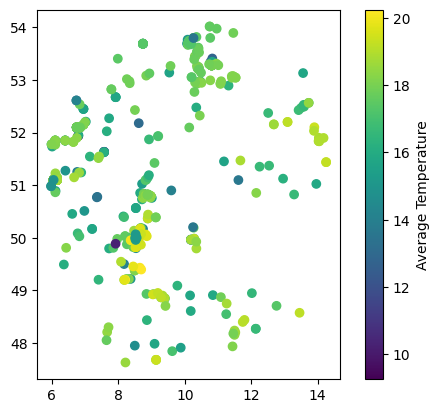

In [22]:
#Request the data from Geo Engine into a geopandas dataframe
data = workflow_calopteryx_splendens_full_avg_temp.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, end_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data.plot(column='Avg_Temperature', legend=True, legend_kwds={'label': 'Average Temperature'})

# Further experiments

In this chapter, some other useful links between Geo Engine and Python are shown.

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


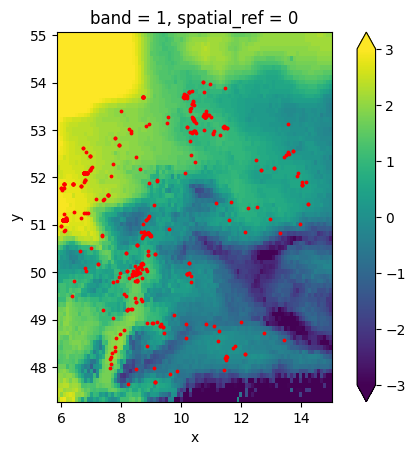

In [23]:
#Overlay plot with context
import geopandas as gpd
import matplotlib.pyplot as plt

#Request the data from Geo Engine into a xarray dataarray
data = workflow_t_avg.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(start_time, start_time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmin=-3, vmax=3)
data_calopteryx_splendens.plot(ax=plt.gca(), color='red', markersize=3)
plt.show()